# Irene J. Ventura Farias
- *Dataset*: https://www.kaggle.com/danielgrijalvas/movies
- Descripción: Dataset que contiene registros de películas desde 1986-2016. Cada película tiene registrado los siguientes features:
    - *budget*: el presupuesto de una película. Algunas películas no lo tienen, por lo que aparece como 0
    - *company*: la compañia de producción
    - *country*: país de origen
    - *director*: director de la película
    - *genre*: género de la pelicula
    - *gross*: ingrésos de la película
    - *name*: nombre
    - *rating*: clasificación de la pelicula
    - *released*: fecha de estreno
    - *runtime*: duración de la película
    - *score*: puntuación de los usuarios de IMDb
    - *votes*: número de votos de los usuarios
    - *star*: actor/ actriz principal
    - *writer*: escritor de la película
    - *year*: año de estreno 
    
- Objetivo: 
#Identificar que campos nos pueden ayudar a predecir  el score de películas según los campos que presenta el dataset y que modelo de regresión 


In [1]:

from pyspark.sql.functions import col, when
from pyspark.sql.types import IntegerType

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt



In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("PySparkShell").getOrCreate()

In [3]:
data = spark.read.csv('movies.csv',
                      mode="DROPMALFORMED",
                      inferSchema=True,
                      header=True)

In [4]:
#Evaluamos el schema del dataframe
data.printSchema()

root
 |-- name: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- genre: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- released: string (nullable = true)
 |-- score: double (nullable = true)
 |-- votes: double (nullable = true)
 |-- director: string (nullable = true)
 |-- writer: string (nullable = true)
 |-- star: string (nullable = true)
 |-- country: string (nullable = true)
 |-- budget: double (nullable = true)
 |-- gross: double (nullable = true)
 |-- company: string (nullable = true)
 |-- runtime: double (nullable = true)



In [5]:
#contabilizamos el numero de registros en el dataframe
total_rows =data.count()
total_rows

7668

In [6]:
# Comprobamos que no hayan duplicados de la misma peli en el mismo año de estreno
total_rows > data.dropDuplicates(['name', "year"]).count()

False

# TEMPORAL

In [13]:
# Evaluamos que campos tienen null 

def count_null_features(df, cols):
    #Evaluamos que columnas tienen nulls
    null_cols = data.toPandas().isnull().any().to_list()
    i = 0
    
    for c in  cols:
        if(null_cols[i] ==  True):
            #Para cada columna que tenga nulls   evaluamos cuantos nulls 
            # presentan sobre el total de registros 
            num = data.filter(data[c].isNull()).count()
            print(c, "--> ", num)
        i = i+1
    
count_null_features(data, data.columns)


rating -->  77
released -->  2
writer -->  3
star -->  1
country -->  3
company -->  17


In [8]:
# Confirmamos que cuando el score es null el votes tambien, por tanto reemplazamos ambos features con 0 
data = data.na.fill({'score': 0.0 , 'votes': 0.0,'budget':0.0, 'gross':0.0, 'runtime': 0.0 })

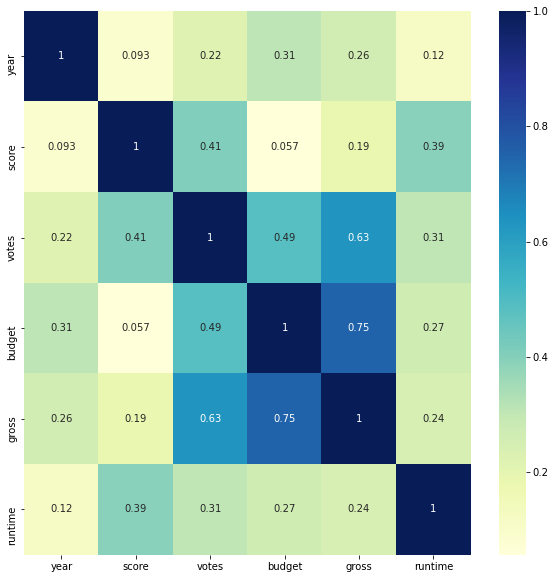

In [9]:
# Calculamos una matriz de correlacion con  los campos numéricos 
def correlation_matrix(data):
    plt.figure(figsize=(10, 10))
    sns.heatmap(data=data.corr(), annot=True, cmap="YlGnBu")
    plt.show()
    
correlation_matrix(data.toPandas())

In [ ]:
# Para el caso nulo por defecto en el campo writer es Unkown, 
# por lo que vamos a mantener la mismo valor para el unico caso de star
data = data.na.fill({'writer': 'Unknown' , 'star': 'Unknown'})

#Sin embargo para el caso concreto de writer existe un escritor anónimo que podemos agruparlo a la misma categoria Unkwon 
data = data.replace(['Anonymous'], ['Unknown'])

In [ ]:
# Basandonos en el Sistema de calificaciones de la Motion Picture Association
# (https://es.wikipedia.org/wiki/Sistema_de_calificaciones_de_la_Motion_Picture_Association)
# Evaluamos todos los tipos de rating en nuestro dataframe   
data.select("rating").distinct().show()

#Mostramos un diagrama circular para ver las categorias actuales de rating
pd = data.groupBy('rating').count().toPandas()
labels = tuple(set(pd['rating'].to_list()))
sizes = pd['count'].to_list()
explode = (0, 0, 0, 0, 0, 0, 0, 0, 0, 0) # 0, 0, 0) 

def show_pie(labels, sizes, explode):
    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    plt.show()

show_pie(labels, sizes, explode)


In [ ]:
# 1- observamos que Not Rated, Unrated representan a las peliculas que no tienen ningun tipo de calificación.
# Por lo que habrá que unifica rambos casos como Unrated y además rellenar los 77 casos null con la misma clásificación
data = data.na.fill({'rating': 'Unrated'})

# 2 - Ademas existen categórías que pueden unificarse entre ellas por lo que vamos a reemplazar ciertas categórías 
data = data.replace(['Not Rated', 'Approved', 'TV-MA', 'TV-PG', 'X', 'TV-14'], ['Unrated', 'G', 'NC-17', 'PG', 'NC-17', 'PG-13'])
data.select("rating").distinct().show()

In [ ]:
#Volvemos a evaluar las etiquetar reagrupadas
pd = data.groupBy('rating').count().toPandas()
labels = tuple(set(pd['rating'].to_list()))
sizes = pd['count'].to_list()
explode = (0, 0, 0, 0, 0, 0) 

show_pie(labels, sizes, explode)

In [10]:
# Model evalluation
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, RandomForestRegressor

def model_evaluation(label, predictions):
    evaluator = RegressionEvaluator(labelCol="score")
    rmse = evaluator.evaluate(predictions)
    print ("Root Mean Squared Error = {0:.4f}".format(rmse))
    evaluator.setMetricName("mse")
    mse = evaluator.evaluate(predictions)
    print ("Mean Squared Error = {0:.4f}".format(mse))
    accuracy = evaluator.evaluate(predictions)
    print("Test Error = " + str(1.0 - accuracy))
    print("\n")
    
def linear_regression(train, test, label):
    lr = LinearRegression(labelCol=label)
    model = lr.fit(train)
    predictions = model.transform(test)
    print("**LINEAR REGRESSION MODEL**")
    model_evaluation(label, predictions)
   
    
def decision_tree_model(train, test, label, features):
    dt = DecisionTreeRegressor(labelCol=label, featuresCol=features)
    model = dt.fit(train)
    predictions = model.transform(test)
    print("** DECISION TREE REGRESSOR MODEL**")
    model_evaluation(label, predictions)
    
def random_forest_model(train, test, label, features):
    rf = RandomForestRegressor(labelCol=label, featuresCol=features)
    model = rf.fit(train)
    predictions = model.transform(test)
    print("**RANDOM FOREST MODEL**")
    model_evaluation(label, predictions)
    
def test_models (data, x, y):
    train, test = data.select(x, y).randomSplit([0.8, 0.2], seed=42)
    
    linear_regression(train, test, y)
    decision_tree_model(train, test, y, x)
    random_forest_model(train, test, y, x)
    

In [11]:
# Features (Modelamos mpg a partir del resto de datos)
from pyspark.ml.feature import VectorAssembler

numerics = [d[0] for d in data.dtypes if not d[1] == "string"]
numerics.remove('score')
numerics.remove('runtime')

assembler = VectorAssembler(inputCols=numerics, outputCol="features")

data= assembler.transform(data)
data.show()

'from pyspark.ml.feature import VectorAssembler\n\nnumerics = [d[0] for d in data.dtypes if not d[1] == "string"]\nnumerics.remove(\'score\')\nnumerics.remove(\'runtime\')\n\nassembler = VectorAssembler(inputCols=numerics, outputCol="features")\n\ndata= assembler.transform(data)\ndata.show()'

In [ ]:
x = "features"
y = "score"

test_models(df,x,y)

In [ ]:
data.dtypes

# Categórico

In [ ]:
# Rellenamos los campos nulos para el resto de columnas , manteniendo el mismo criterio que en las que modificamos previamente 
data = data.na.fill({'country': 'Unknown', 'company': 'Unknown'})

In [ ]:
# La columna released nos la quitamos ya que tenemos el campo year, name es equivalente al id
data = data.drop("released", 'name')
#Comprobamos que ya no tenemos campos nulos
count_null_features(data, data.columns)

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer,  VectorAssembler, OneHotEncoder

# Separamos en dos variables una lista con las columnas numericas y otra con las categoricas 

categories = [d[0] for d in data.dtypes if d[1] == "string"]

cindex_name = [col + "_index" for col in categories]
cencoded_name = [col + "_encoded" for col in categories]



indexer = StringIndexer(inputCols=categories, outputCols=cindex_name)

encoder = OneHotEncoder(inputCols=cindex_name, outputCols=cencoded_name)

assembler = VectorAssembler(
   
    inputCols=[col for col in cencoded_name if col != "score_encoded"] ,
    outputCol="features",
)

pipeline = Pipeline(stages=[indexer, encoder, assembler])
data = pipeline.fit(data).transform(data)

In [ ]:
# Generamos de nuevo una matriz de correlación 
correlation_matrix(data.toPandas())

In [ ]:
from pyspark.ml.regression import DecisionTreeRegressor

In [ ]:
from pyspark.ml.classification import RandomForestClassifier